# Data Exploration: `Intermediate_data_01`

#### Objectives:
1. What is the distribution of the number of times each gene is sampled?
2. What is the distribution of the proportion of papers that found >2-fold difference for each gene?
3. Are we looking at substantially diminishing returns of new unique candidate genes per dataset processed already?
4. What proportion of TAG synthesis pathway genes are included in this set of unique genes?

#### New candidate_gene inclusion criteria:
- showed up as `True` in at least **one comparison per paper** AND in at least **two papers**

x-axis: number of datasets

In [1]:
import pickle
import random
import pandas as pd
import numpy as np
import statistics as stats
import random
from matplotlib import pyplot as plt
import time
import re

In [2]:
#p = open("../../data/intermediate_data_02/matches", "rb")
matches = pd.read_pickle("../../data/intermediate_data_02/matches")
#matches = pickle.load(p)
match_summary = pd.read_csv("../../data/intermediate_data_02/match_summary.csv")
match_summary["firstauthor_year"] = match_summary["first_author"] + "_"+match_summary["year"].astype(int).astype(str)
print(match_summary)
matches[:5]

  first_author    year  matches  mismatches    total  proportion_of_matches  \
0        Hemme  2014.0   1894.0        86.0   1980.0               0.956566   
1     Bajhaiya  2016.0  17736.0         1.0  17737.0               0.999944   
2   Goodenough  2014.0     66.0         2.0     68.0               0.970588   
3        Blaby  2013.0    591.0        51.0    642.0               0.920561   
4        Boyle  2012.0     24.0         1.0     25.0               0.960000   
5     Juergens  2015.0     96.0         9.0    105.0               0.914286   
6         Kwak  2017.0    850.0         0.0    850.0               1.000000   
7     Gargouri  2015.0    414.0         0.0    414.0               1.000000   

  firstauthor_year  
0       Hemme_2014  
1    Bajhaiya_2016  
2  Goodenough_2014  
3       Blaby_2013  
4       Boyle_2012  
5    Juergens_2015  
6        Kwak_2017  
7    Gargouri_2015  


,gene_id,included,source,total_comparisons
0,Cre01.g000350.t1.1,0,Hemme_2014,1
1,Cre01.g000850.t1.2,0,Hemme_2014,1
2,Cre01.g001100.t1.2,0,Hemme_2014,1
3,Cre01.g001300.t1.1,0,Hemme_2014,1
4,Cre01.g002300.t1.2,0,Hemme_2014,1


### Categorize gene_ids as candidate genes based on cut-off

`Candidate_gene` new criteria: detected as candidate gene in **at least one comparison per paper** AND in **at least two papers**


In [3]:
#random.seed(1)
#random.shuffle()
cut_off = 0.75
num_papers = 8
count = 0
list_temp =[]
candidates = {}

In [4]:
type(matches)

pandas.core.frame.DataFrame

#### 1. What is the distribution of the number of times each gene is sampled?

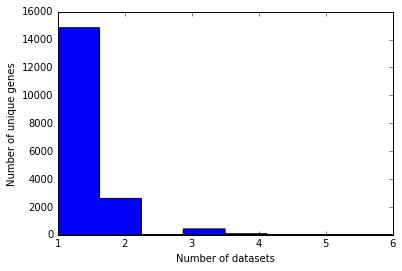

In [5]:
#Distribution of number of times each gene is sampled
num_sampled = matches.groupby('gene_id').agg('size')

fig, ax = plt.subplots()
plt.hist(num_sampled, bins = 8, histtype = 'stepfilled')
ax.set_xlabel('Number of datasets')
ax.set_ylabel('Number of unique genes')
plt.savefig('distribution_of_genes_detected.png', bbox_inches = "tight", dpi = 300)   


In [6]:
df= pd.DataFrame.from_dict({"Count": num_sampled.value_counts().index,
                            "Number_of_genes": num_sampled.value_counts()})
print("Count = number of studies that sampled the gene")
print (df)

Count = number of studies that sampled the gene
   Count  Number_of_genes
1      1            14843
2      2             2607
3      3              421
4      4               75
5      5                9
6      6                1


#### 2. What is the distribution of the proportion of papers that found >2-fold difference for each gene?

- After filtering out genes sampled by only one paper

In [7]:
grouped = matches.groupby('gene_id')

count = 0
for name, group in grouped:
    count+=1
    if count <5: print(group, "\n")
    else: break

                  gene_id  included         source  total_comparisons
16914  Cre01.g000017.t1.1         0  Bajhaiya_2016                  4
20407  Cre01.g000017.t1.1         0      Kwak_2017                  2 

                  gene_id  included         source  total_comparisons
17337  Cre01.g000033.t1.1         1  Bajhaiya_2016                  4 

                  gene_id  included         source  total_comparisons
21257  Cre01.g000050.t1.1         0  Gargouri_2015                  7 

                 gene_id  included         source  total_comparisons
1894  Cre01.g000100.t1.1         0  Bajhaiya_2016                  4 



In [8]:
num_detected= grouped['included'].apply(lambda x: len(list(x)) - list(x).count(0))
print(num_detected[:5])
num_sampled = matches.groupby('gene_id').agg('size')
df= pd.DataFrame.from_dict({"num_detected": num_detected,
                            "num_sampled": num_sampled,
                           "gene_id": num_sampled.index, 
                           'proportion': num_detected.apply(lambda x: x/num_papers) })
#
print(df[:5])

gene_id
Cre01.g000017.t1.1    0
Cre01.g000033.t1.1    1
Cre01.g000050.t1.1    0
Cre01.g000100.t1.1    0
Cre01.g000150.t1.2    1
Name: included, dtype: int64
                               gene_id  num_detected  num_sampled  proportion
gene_id                                                                      
Cre01.g000017.t1.1  Cre01.g000017.t1.1             0            2       0.000
Cre01.g000033.t1.1  Cre01.g000033.t1.1             1            1       0.125
Cre01.g000050.t1.1  Cre01.g000050.t1.1             0            1       0.000
Cre01.g000100.t1.1  Cre01.g000100.t1.1             0            1       0.000
Cre01.g000150.t1.2  Cre01.g000150.t1.2             1            1       0.125


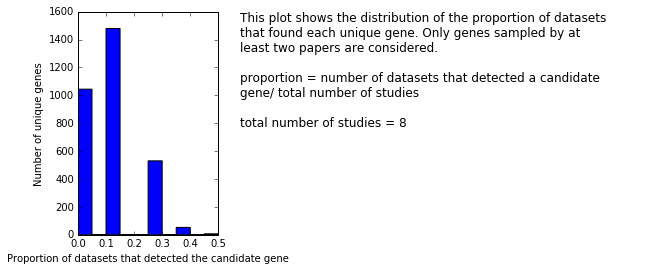

In [9]:
fig, ax = plt.subplots()
plt.hist(df.proportion[df.num_sampled>=2], bins = 10, histtype = 'stepfilled')
ax.set_xlabel('Proportion of datasets that detected the candidate gene')
ax.set_ylabel('Number of unique genes')
caption ="This plot shows the distribution of the proportion of datasets\n \
            that found each unique gene. Only genes sampled by at\n \
            least two papers are considered.\n\n \
            proportion = number of datasets that detected a candidate \n \
            gene/ total number of studies \n\n \
            total number of studies = 8"
plt.subplots_adjust(right =.45)
plt.figtext(0.5, 0.5, caption, fontsize=12, ha = 'left', wrap = True )
plt.savefig('Proportion_of_datasets.png', bbox_inches = "tight", dpi = 300)


In [10]:
df['source']= grouped['source'].apply(lambda x: list(x))
print(df[:5])

                               gene_id  num_detected  num_sampled  proportion  \
gene_id                                                                         
Cre01.g000017.t1.1  Cre01.g000017.t1.1             0            2       0.000   
Cre01.g000033.t1.1  Cre01.g000033.t1.1             1            1       0.125   
Cre01.g000050.t1.1  Cre01.g000050.t1.1             0            1       0.000   
Cre01.g000100.t1.1  Cre01.g000100.t1.1             0            1       0.000   
Cre01.g000150.t1.2  Cre01.g000150.t1.2             1            1       0.125   

                                        source  
gene_id                                         
Cre01.g000017.t1.1  [Bajhaiya_2016, Kwak_2017]  
Cre01.g000033.t1.1             [Bajhaiya_2016]  
Cre01.g000050.t1.1             [Gargouri_2015]  
Cre01.g000100.t1.1             [Bajhaiya_2016]  
Cre01.g000150.t1.2             [Bajhaiya_2016]  


In [11]:
print("Total number of candidates after filtering: ", len(df.proportion[df.num_detected>=2 ]))

Total number of candidates after filtering:  590


#### Export dataframe of unique genes with dataset information to `data/intermediate_data_02/`

In [12]:
pickle_out = open("../../data/intermediate_data_02/int_data02", "wb")
pickle.dump(df, pickle_out)
pickle_out.close()

#### 3. Are we looking at substantially diminishing returns of new unique candidate genes per dataset processed already?

Simulate dataset collection by randomly sample all datasets without replacements and calculate the number of new unique candidate genes per dataset. Repeat this simulation `rep` times.

`uniq` dictionary structure:

`uniq = { [ nth sampled dataset <int> ] : number of unique candidate genes <int> }`

In [13]:
df = pd.read_pickle("../../data/intermediate_data_02/int_data02")
omit = []
rep = 100
uniq = dict((key,[0]*rep) for key in range(1,len(list(np.unique(match_summary.firstauthor_year)))+1))
#print(uniq)

In [14]:
#condition1 = df.source.apply(lambda x: len(x)>=2)
condition2 = df.num_detected.apply(lambda x: x>=2)

In [15]:
t0 = time.time()
df = df[condition2]
df_dict = dict(zip(df.gene_id, df.source))
shuffled_ls = list(match_summary.firstauthor_year)

for r in range(rep):
    
    #Randomly reorder datasets
    random.seed(r)
    random.shuffle(shuffled_ls)
    
    #Keep a list of sampled datasets
    omit = []
    
    for i in range(len(shuffled_ls)): 
        
        #If sample dataset is in match_summary and none of the sampled datasets in omit list is in candidates[gene], 
        #number of unique candidate genes detected by the dataset +1.
        
        for gene in df_dict.keys():
            
            #If sample dataset is in candidates[gene] and none of the sampled datasets in omit list is in candidates[gene], number of unique candidate genes detected by the dataset +1.
            if any(shuffled_ls[i] in value for value in df_dict[gene]) and any(counted in value for value in df_dict[gene] for counted in omit) ==False :
                
                uniq[i+1][r]+=1

            else: pass
        
        #Add sampled dataset to omit list once all the genes have been accounted for
        omit.append(shuffled_ls[i])

t1 = time.time()    
print("Simulation of", rep, "times took", t1-t0, "sec.")

Simulation of 100 times took 0.6614511013031006 sec.


Convert `uniq` dictionary to `df` dataframe. 

**`df`** dataframe structure:


| 1         	| 2                   	| 3                             	| ... 	| `rep` 	| average 	| SD 	|
|-----------------------------------------	|-------              	|-------                        	|-------	|-------	|----------------------	|----------------------------------	|
| cumsum(number of unique genes)<br>`<int>` 	| `<int>` 	| `<int>` 	| `<int>` 	| `<int>` 	| RowAverage <br>`<int>` 	| RowStandardDeviation <br>`<float>` 	|

**`rep`**: `<int>` number of simulations

In [16]:
df = pd.DataFrame.from_dict(uniq, orient = "index")
for col in df.columns:
    df[col] = df[col].cumsum()
df['average'] = df.mean(axis=1)

df['SD'] = df[df.columns[range(rep)]].std(axis=1)

In [17]:
col_names = ['dataset_num', 'cumsum']
reshaped_df= pd.DataFrame(columns = col_names)

for col in df.columns[range(rep)]:
    
    temp = df[col].reset_index()
    temp.columns =['dataset_num', 'cumsum']
    #temp['cumsum'] = temp['unique_genes'].cumsum()
    reshaped_df= pd.concat([reshaped_df, temp])
    
#print(reshaped_df)

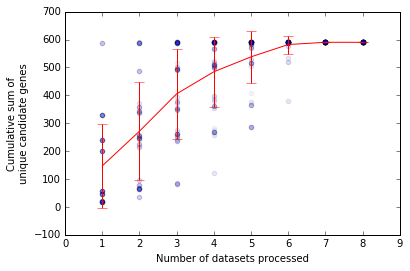

In [18]:
fig, ax = plt.subplots()

plt.scatter(x='dataset_num', y='cumsum', data = reshaped_df, alpha = 0.05, zorder =2)
ax.errorbar(list(df.index), list(df.average),
       yerr=list(df.SD),
       alpha=1,
       color='red',
       capsize=5)
ax.set_xlabel('Number of datasets processed')
ax.set_ylabel('Cumulative sum of\nunique candidate genes')
#plt.show()
plt.savefig('cumulative_unique_genes.png', bbox_inches = "tight", dpi = 300)

#### 4. What proportion of TAG synthesis pathway genes are included in this set of unique genes?
*C. reinhardtii* TAG synthesis pathway genes are downloaded from BioCyc (accessed on May 20, 2020)

In [19]:
#Import TAG synthesis pathway genes
TAG_genes= pd.read_csv("../../data/raw_data/lipid_pathway_genes/triacylglycerol_biosynthesis.txt",skiprows = 1, delimiter = "\t")
TAG_genes = pd.Series(TAG_genes["Enzymatic activity"].values, index=TAG_genes["Gene Accession"]).to_dict()

print("Number of TAG synthesis pathway genes:", len(TAG_genes))

Number of TAG synthesis pathway genes: 26


In [20]:
candidate_TAG_genes ={}
for key in df_dict.keys():
    if key in TAG_genes: candidate_TAG_genes[key] = TAG_genes[key]
df = pd.DataFrame(data=list(candidate_TAG_genes.items()), columns= ['gene_id', 'enzyme'])
print("Number of TAG synthesis pathway genes detected as candidate genes:", len(candidate_TAG_genes),'\n' ,df)

Number of TAG synthesis pathway genes detected as candidate genes: 4 
               gene_id                                       enzyme
0  Cre02.g106400.t1.1  phospholipid:diacylglycerol acyltransferase
1  Cre09.g386912.t1.1             diacylglycerol O-acyltransferase
2  Cre01.g045903.t1.1             diacylglycerol O-acyltransferase
3  Cre12.g557750.t1.1             diacylglycerol O-acyltransferase


##### Repeat above with superpathways of fatty acid and acetylco-A biosynthesis

In [22]:
file_path = ['../../data/raw_data/lipid_pathway_genes/superpathway_of_fatty_acid_biosynthesis_II.txt',
             '../../data/raw_data/lipid_pathway_genes/superpathway_of_acetyl-CoA_biosynthesis.txt']

for file in file_path:
    candidate_pathway_genes ={}
    pathway_genes= pd.read_csv(file,skiprows = 1, delimiter = "\t")
    pathway_genes= pd.Series(pathway_genes["Enzymatic activity"].values, index=pathway_genes["Gene Accession"]).to_dict()
    for key in df_dict.keys():
        if key in pathway_genes: candidate_pathway_genes[key] = pathway_genes[key]
    df = pd.DataFrame(data=list(candidate_pathway_genes.items()), columns= ['gene_id', 'enzyme'])
    print(file, len(pathway_genes))
    print("Number pathway genes detected as candidate genes:", len(candidate_pathway_genes),'\n' ,df)
    

../../data/raw_data/lipid_pathway_genes/superpathway_of_fatty_acid_biosynthesis_II.txt 29
Number pathway genes detected as candidate genes: 15 
                gene_id                                           enzyme
0   Cre11.g467723.t1.1    beta-ketoacyl-acyl-carrier-protein synthase I
1   Cre17.g715250.t1.2                           acetyl-CoA carboxylase
2   Cre12.g484000.t1.2                           acetyl-CoA carboxylase
3   Cre08.g359350.t1.2                           acetyl-CoA carboxylase
4   Cre12.g507400.t1.2                 long-chain-fatty-acid-CoA ligase
5   Cre04.g216950.t1.2  beta-ketoacyl-acyl-carrier-protein synthase III
6   Cre03.g208050.t1.2                          fatty-acyl-CoA synthase
7   Cre02.g088250.t1.2                               Cre02.g088250.t1.2
8   Cre08.g373050.t1.1                           acetyl-CoA carboxylase
9   Cre03.g182050.t1.2                 long-chain-fatty-acid-CoA ligase
10  Cre06.g294950.t1.1    enoyl-[acyl-carrier-protein] reductas